## **Bicycle counts on Seattle’s Fremont Bridge.**
### This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.
The count fields represent the total bicycles detected during the specified one hour period. Direction of travel is not specified, but in general most traffic in the Fremont Bridge NB field is travelling northbound and most traffic in the Fremont Bridge SB field is travelling southbound.

### Import Libraries 

In [1]:
# This Python 3 environment - Import Libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt 
import seaborn as sns

***index_col:** This is to allow you to set which columns to be used as the index of the dataframe. The default value is None, and pandas will add a new column start from 0
**parse_dates:** Convert Columns into Datetime When Using pandas to Read CSV*

### Load Data

In [2]:
#specify Date as an index, 
#dates automatically parsed
bridge_data = pd.read_csv("/kaggle/input/fremont-bridge/fremont-bridge.csv", index_col ="Date", parse_dates = True)
bridge_data.head(1)

,West,East
Date,,
2012-10-03,4.0,9.0


### adding a “Total” column: compine west and east

In [3]:
bridge_data.columns

Index(['West', 'East'], dtype='object')

In [4]:
bridge_data["Total"] = bridge_data['West'] + bridge_data['East']
bridge_data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


### summary statistics for the bridge data

In [5]:
bridge_data.dropna().describe() 

,West,East,Total
count,45976.000000,45976.000000,45976.000000
mean,54.712306,55.479315,110.191622
std,72.935797,80.232055,139.189603
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,28.000000,60.000000
75%,72.000000,68.000000,144.000000
max,854.000000,717.000000,1165.000000


### EDA : Visualizing the data

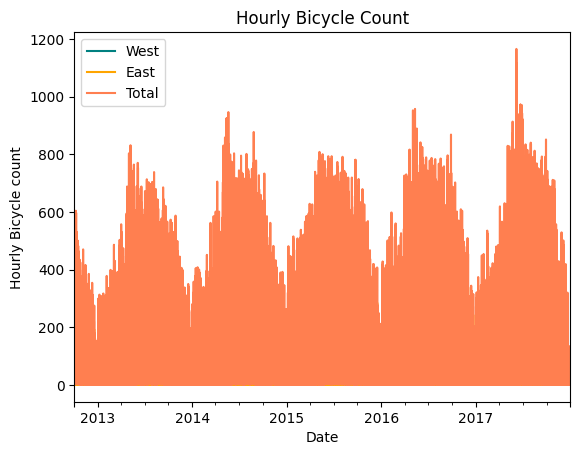

In [6]:
bridge_data.plot(color=['teal', 'orange', 'coral'])
plt.ylabel("Hourly Bicycle count")
plt.title('Hourly Bicycle Count')
plt.show()

#### ~25,000 hourly samples are far too dense for us to make much sense of. We can gain more insight by resampling the data to a coarser grid.
#### Resample by Year, Month, Week, Day, and time
####  [Python Resample Time Series Options List and Example](http://benalexkeen.com/resampling-time-series-data-with-pandas/)

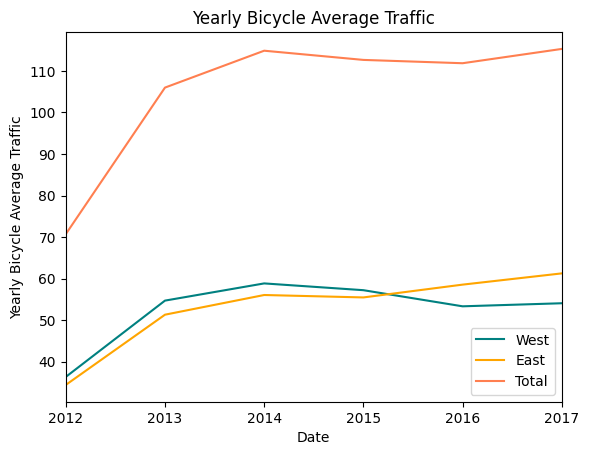

In [7]:
# Resampling data with Year

yearly_data = bridge_data.resample("YE").mean()
yearly_data.plot(color=['teal', 'orange', 'coral'])
#weekly_data.plot(style=[':', '--', '-'])
plt.ylabel('Yearly Bicycle Average Traffic')
plt.title("Yearly Bicycle Average Traffic")
plt.show()

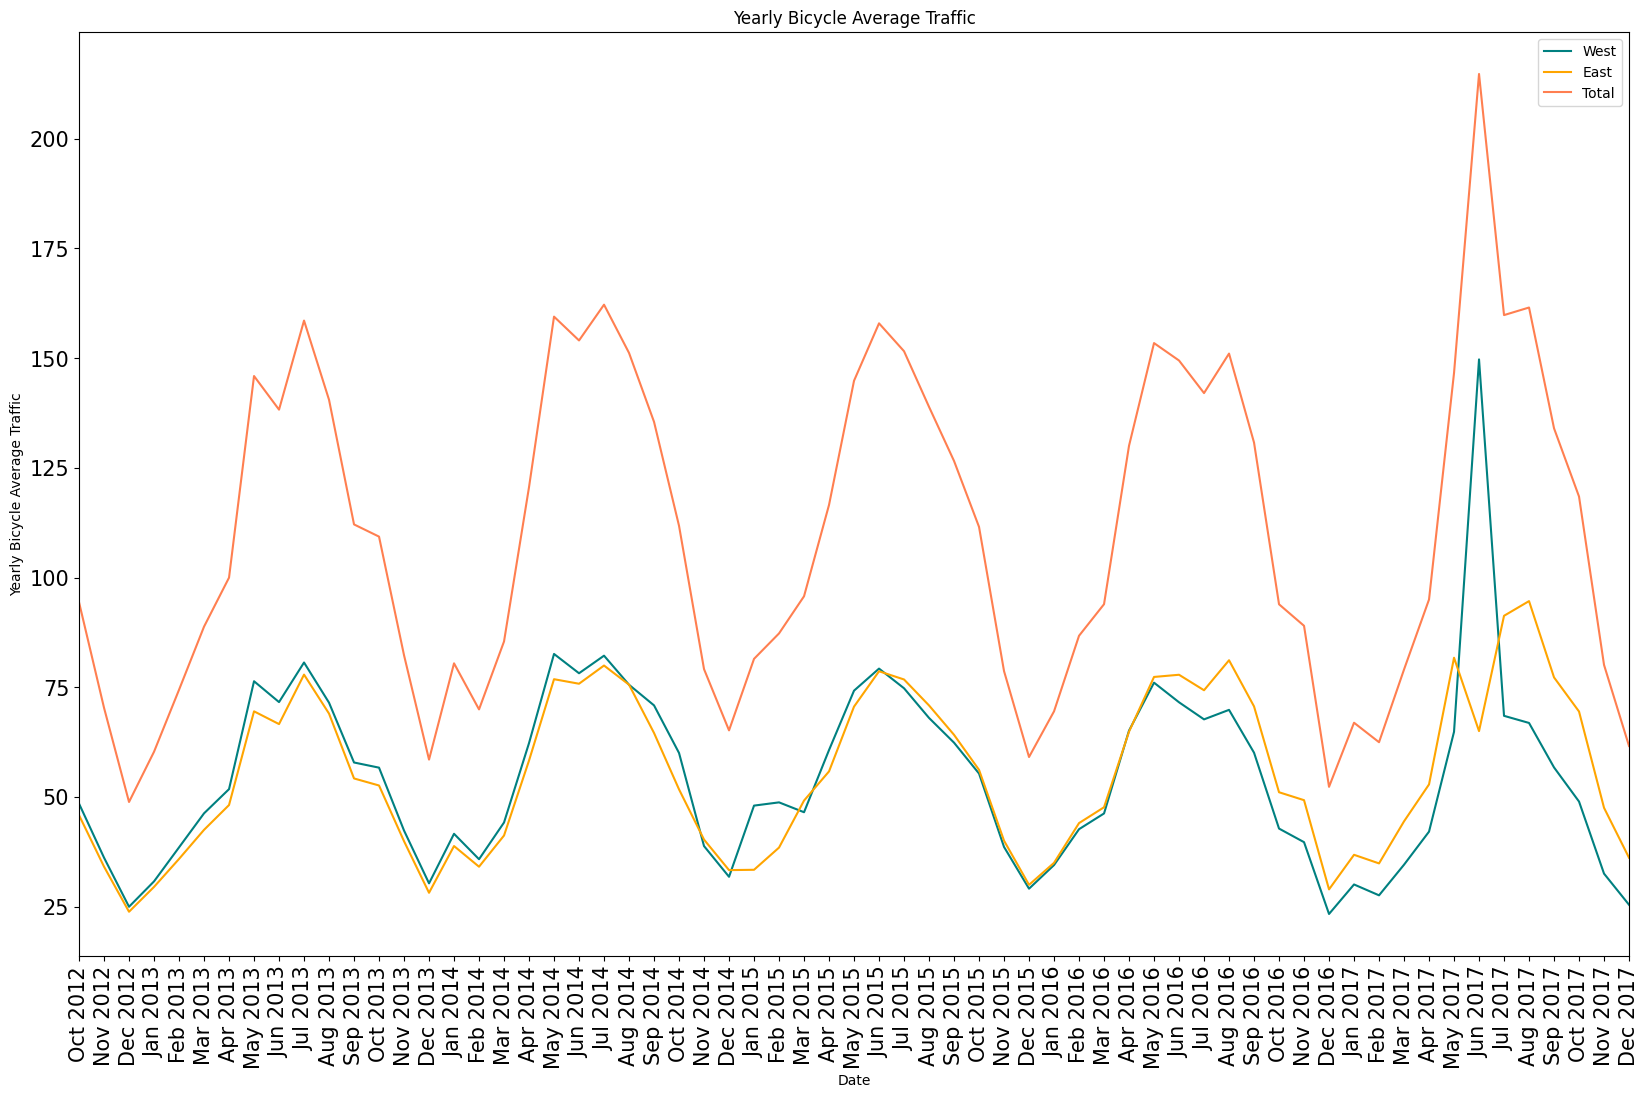

In [8]:
# Resampling data with Month

monthly_data = bridge_data.resample("ME").mean()
monthly_data.plot(color=['teal', 'orange', 'coral'],figsize=(20, 12))
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b %Y'), rotation=90)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Yearly Bicycle Average Traffic')
plt.title("Yearly Bicycle Average Traffic")
plt.show()

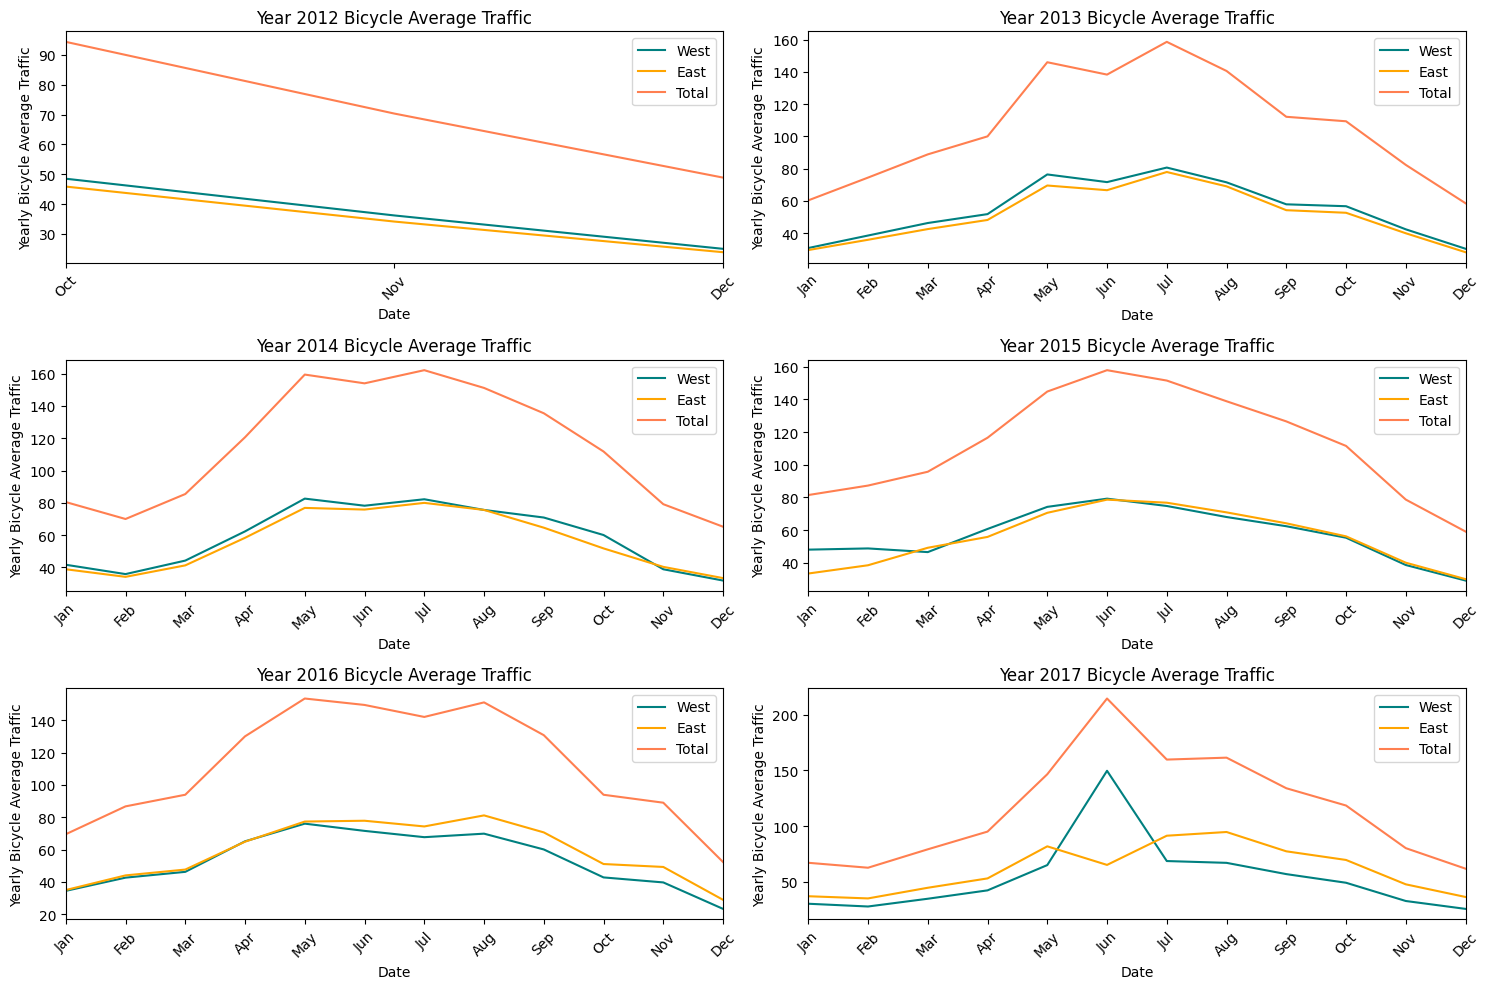

In [9]:
# Resampling data with Month
monthly_data = bridge_data.resample("ME").mean()

# Get unique years
years = monthly_data.index.year.unique()

# Calculate number of rows and columns for subplots
num_rows = (len(years) + 1) // 2  # Add 1 to round up
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten axes if necessary
if len(years) > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot data for each year separately
for i, year in enumerate(years):
    data = monthly_data[monthly_data.index.year == year]
    ax = axes[i]
    data.plot(ax=ax, color=['teal', 'orange', 'coral'])
    ax.set_xticks(data.index)
    ax.set_xticklabels(data.index.strftime('%b'), rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylabel('Yearly Bicycle Average Traffic')
    ax.set_title(f"Year {year} Bicycle Average Traffic")

# Adjust layout
plt.tight_layout()
plt.show()


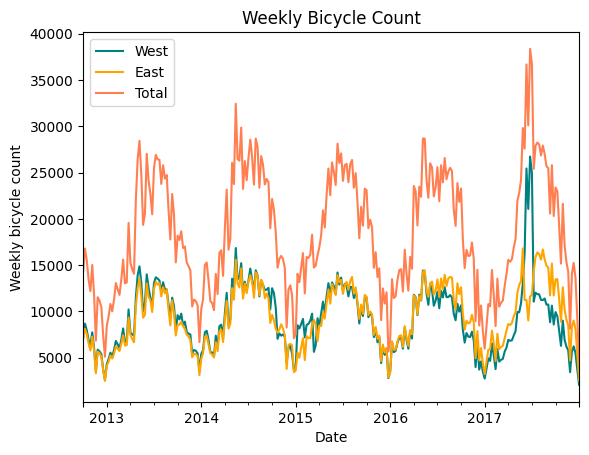

In [10]:
# Resampling data with Week

weekly_data = bridge_data.resample("W").sum()
weekly_data.plot(color=['teal', 'orange', 'coral'])
#weekly_data.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')
plt.title("Weekly Bicycle Count")
plt.show()

#### This shows interesting seasonal trends: People bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week.

####  taking a snapshot of the sum of values around each day, which helps to smooth out sudden changes and highlight broader trends in the data.
#### let's look at our data one day at a time, and for each day, let's sum up the values of that day plus the 15 days before and 15 days after it ( set center=True and 30 is the window size)."

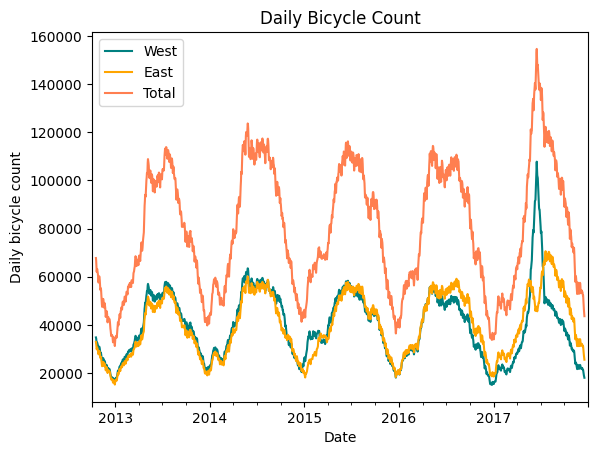

In [11]:
##### Resampling data with Day

daily_data = bridge_data.resample("D").sum()
daily_data.rolling(30,center = True).sum().plot(color=['teal', 'orange', 'coral'])
plt.ylabel('Daily bicycle count')
plt.title("Daily Bicycle Count")
plt.show()

#### The jaggedness of the result is due to the hard cutoff of the window. We can get a smoother version of a rolling mean using a window function—for example, a Gaussian window.



*win_typestr, default None
If a string, it must be a valid scipy.signal **window function.**
Certain Scipy window types **require additional parameters** to be passed in the aggregation function. The additional parameters **must match the keywords specified** in the Scipy window type method signature.*
[Window functions](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)

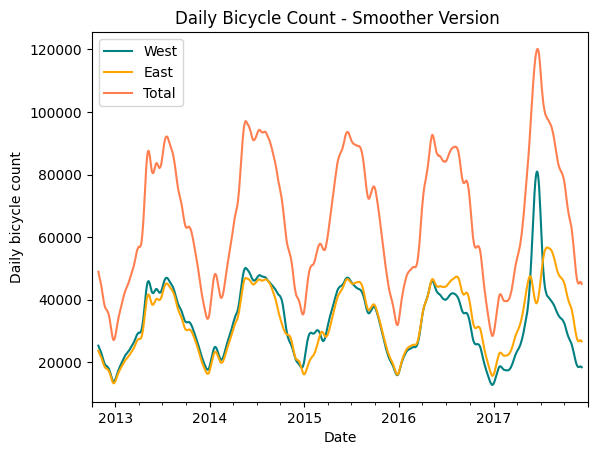

In [12]:
##### Resampling data with Day and Window Finction

daily_data = bridge_data.resample("D").sum()
daily_data.rolling(50,center = True,
                  win_type='gaussian').sum(std=10).plot(color=['teal', 'orange', 'coral'])
plt.ylabel('Daily bicycle count')
plt.title("Daily Bicycle Count - Smoother Version ")
plt.show()

#### smoothed data views are useful to get an idea of the general trend in the data, they hide much of the interesting structure. We might want to look at the average traffic **as a function of the time of day.** 
We can do this using the GroupBy:

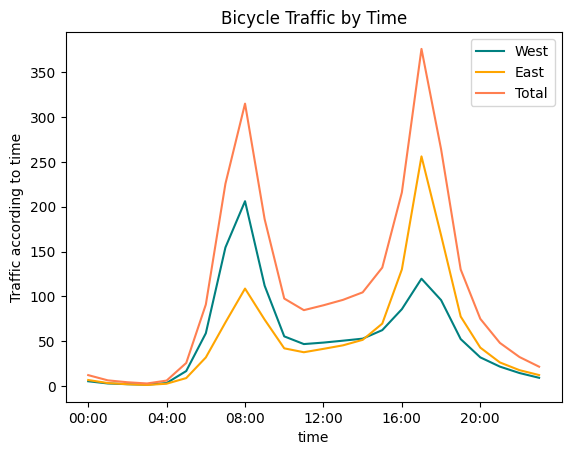

In [13]:
time_data = bridge_data.groupby(bridge_data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
time_data.plot(xticks = hourly_ticks  , color=['teal', 'orange', 'coral'])
plt.title("Bicycle Traffic by Time")
plt.ylabel("Traffic according to time")
plt.show()

#### We can notice from the pattern: in the mornings the traffic on the east is greater and at noon it's greater on the west